# Answering Business questions with SQL
This project aims to explore a database, answer various business questions by means of quering and visualizing data, using sql and pandas.

This project inquires the Chinook database, a music store.

The idea is to answer certain business questions, visualize and give recommendations based on gathered data.

**The questions to address:**
- [Which genre is most popular in America?](#Which-genre-is-most-popular-in-America?)
- [Employee performance: if differs is there an explanation, or is it a genuine difference.](#Employee-performance)
- [Purchase by country: which countries are have potential to focus marketing force on.](#Purchases-by-Country)
- [What is the percentage of Full Album purchases?](#Full-Album-Purchases)
- [Most popular Artists.](#Most-popular-artist)
- [Overall track purchased vs non-purchased.](#Tracks-Purchased-vs-non-Purchased)
- [Does a track range presented in the store reflect tracks been purchased by the customers?](#Track-range-to-popularity)
- [Does media type affects popularity?](#Media-type-to-popularity)

**Schema of the database** we'll be working with:
![title](img/chinook_db_schema.png)

In [3]:
import sqlite3
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Define functions to ease interaction with chinook.db database

In [4]:
# A function, that takes a SQL query as an argument
# and returns a pandas dataframe of that query.
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query,conn)
    
# A function that takes a SQL command as an argument and executes it using the sqlite module.
def run_command(query_command):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(query_command)
    
# A function that calls the run_query() function to return a list of all tables and views in the database.
def show_tables():
    query = 'SELECT name, type \
            FROM sqlite_master \
            WHERE type IN (\'table\',\'view\')'
    return run_query(query)

Run the show_tables() function to see current database state.

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


Chinook schema database looks as following:

### Which genre is most popular in America?
Write a query that returns each genre, with the number of tracks sold in absolute numbers and in percentages.

Then visualize it, and recommend which 3 genres are most prolific to sell in USA.

In [6]:
query ='\
WITH total_usa_tracks AS \
    (SELECT inv.billing_country country, \
         SUM(inv_line.quantity) tot_usa_tracks \
    FROM invoice inv \
    INNER JOIN invoice_line inv_line ON inv.invoice_id=inv_line.invoice_id \
    WHERE country=\'USA\' ) \
\
SELECT inv.billing_country country, \
    SUM(inv_line.quantity) tracks_total, \
    CAST(SUM(inv_line.quantity) AS float)/CAST(t_us_tr.tot_usa_tracks AS float)*100 percentage, \
    genre.name genre_name \
FROM invoice inv \
INNER JOIN invoice_line inv_line ON inv.invoice_id=inv_line.invoice_id \
INNER JOIN track track ON track.track_id=inv_line.track_id \
INNER JOIN genre genre ON genre.genre_id=track.genre_id \
INNER JOIN total_usa_tracks t_us_tr ON t_us_tr.country=country \
GROUP BY genre_name \
HAVING inv.billing_country=\'USA\' \
ORDER BY tracks_total DESC; \
'
run_query(query)

,country,tracks_total,percentage,genre_name
0,USA,619,58.896289,Metal
1,USA,159,15.128449,R&B/Soul
2,USA,124,11.798287,Blues
3,USA,121,11.512845,Jazz
4,USA,63,5.994291,Pop
5,USA,33,3.139867,Hip Hop/Rap
6,USA,8,0.761180,Heavy Metal
7,USA,2,0.190295,TV Shows


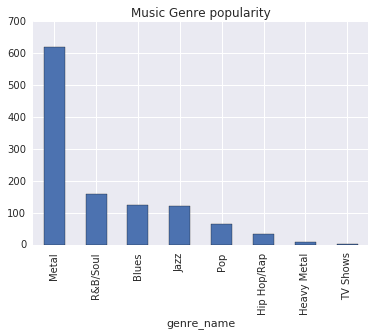

In [7]:
usa_track_genres_df = run_query(query)
usa_track_genres_df.set_index('genre_name', inplace=True, drop=True)
usa_track_genres_df['tracks_total'].plot.bar()
plt.title('Music Genre popularity')
plt.show()

#### Conclusion
We can clearly see most selling music genres in USA as for chinook database.

As for the label which consider to distribute Hip-Hop, Punk, Pop, Blues, we I would recommend to focus mostly on Blues, and Pop, and maybe on less popular Hip-Hop. Also bear in mind that Punk seem not popular whatsoever.

### Employee performance
Compare employee performance, by the total sales in USD.

Possibly find out if employee performance variance depends on any other data:
- country
- state
- age
- hire date
- title

In [8]:
query = '\
SELECT \
    emp.first_name||\' \'||emp.last_name name, \
    emp.hire_date, \
    emp.birthdate, \
    emp.title, \
    emp.country country, \
    emp.state, \
    SUM(i.total) total_sales \
    FROM employee emp \
    INNER JOIN customer c ON c.support_rep_id=emp.employee_id \
    INNER JOIN invoice i ON i.customer_id=c.customer_id \
    GROUP BY name \
    ORDER BY total_sales \
'
run_query(query)

,name,hire_date,birthdate,title,country,state,total_sales
0,Steve Johnson,2017-10-17 00:00:00,1965-03-03 00:00:00,Sales Support Agent,Canada,AB,1393.92
1,Margaret Park,2017-05-03 00:00:00,1947-09-19 00:00:00,Sales Support Agent,Canada,AB,1584.00
2,Jane Peacock,2017-04-01 00:00:00,1973-08-29 00:00:00,Sales Support Agent,Canada,AB,1731.51


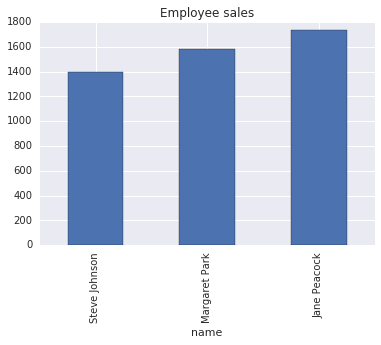

In [9]:
employee_performance_df = run_query(query)
employee_performance_df.set_index('name', inplace=True, drop=True)
employee_performance_df['total_sales'].plot.bar()
plt.title('Employee sales')
plt.show()

#### Conclusion
We can see total sales by each employee. Also we could see that performance variance directly correlates to the employee hire date.

So, the reason of those differences is the hire date.

### Purchases by Country
Collate data on purchases from different countries, for each country include:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [10]:
query = '''
WITH cust_per_country AS
    (SELECT
         COUNT(c.customer_id) tot_cust,
         c.country country
     FROM customer c\
     GROUP BY c.country
    ),
    
    sales_per_country AS
    (SELECT 
        SUM(i.total) tot_sales,
        c.country country
     FROM customer c
     INNER JOIN invoice i ON i.customer_id=c.customer_id
     GROUP BY country
    ),
    
    order_per_country AS
    (SELECT 
         COUNT(i.invoice_id) tot_orders,
         c.country country
     FROM customer c
     INNER JOIN invoice i ON i.customer_id=c.customer_id
     GROUP BY country
    ),

    merged_table AS
    (SELECT cust.country country,
        cust.tot_cust tot_cust,
        sales.tot_sales total_sales,
        CAST(sales.tot_sales AS float)/CAST(cust.tot_cust AS float) avg_per_cust,
        CAST(sales.tot_sales AS float)/CAST(orders.tot_orders AS float) avg_order_val
        FROM cust_per_country cust
        INNER JOIN sales_per_country sales ON sales.country=cust.country
        INNER JOIN order_per_country orders ON orders.country=sales.country
    ),
        
    merged_table_labeled AS
    (SELECT
        mtable.country country,
        mtable.tot_cust tot_cust,
        mtable.total_sales total_sales,
        mtable.avg_per_cust avg_per_cust,
        mtable.avg_order_val avg_order_val,
        CASE
            WHEN mtable.tot_cust = 1 THEN 'Other'
            ELSE mtable.country
        END AS country_labeled
    FROM merged_table mtable)
    
    SELECT
        mtable_l.country country,
        SUM(mtable_l.customers) customers,
        SUM(mtable_l.sales) sales,
        CAST(SUM(mtable_l.avg_per_cust) AS float)/COUNT(mtable_l.country) avg_per_cust,
        CAST(SUM(mtable_l.avg_order_val)AS float)/COUNT(mtable_l.country) avg_order_val
    FROM (
        SELECT
            mtable_l.country_labeled country,
            mtable_l.tot_cust customers,
            mtable_l.total_sales sales,
            mtable_l.avg_per_cust avg_per_cust,
            mtable_l.avg_order_val avg_order_val,
            CASE
                WHEN mtable_l.country_labeled = 'Other' THEN 0
                ELSE 1
            END AS country_class
        FROM merged_table_labeled as mtable_l) mtable_l
    GROUP BY mtable_l.country
    ORDER BY mtable_l.country_class DESC,sales DESC
    
'''
run_query(query)

,country,customers,sales,avg_per_cust,avg_order_val
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.445071


#### Visualization

In [11]:
country_purchase_df = run_query(query)
country_purchase_df.set_index('country', inplace=True, drop=True)

In [12]:
def avg_customer_purchase():
    fig = plt.figure(figsize=(16,12))
    # Add a subplot
    ax = fig.add_subplot(111)
    # Set title
    ttl = 'Average Customer purchase per Country'

    country_purchase_df['avg_per_cust'].plot.bar(ax=ax, alpha=0.7)
    ax.axhline(85, lw=1, c='red', linestyle='--')
    ax.set_ylim([40,150])
    ax.set_title(ttl,fontsize=18)

    countries = country_purchase_df.index.values.tolist()
    for i, bar in enumerate(ax.patches):
        height = bar.get_height()
        country = countries[i]
        if height > 85:
            ax.text(bar.get_x() + bar.get_width()/2, (height+height*0.03), '{}'.format(country), 
                         ha='center', color='black', fontsize=14, alpha=0.85)
            bar.set_edgecolor('black')
            bar.set_linewidth(2)
            bar.set_alpha(1)

    plt.show()

In [13]:
def total_sales_per_country():
    fig2 = plt.figure(figsize=(16,12))
    # Add a subplot
    ax = fig2.add_subplot(111)
    # Set title
    ttl = 'Sales per Country'

    country_purchase_df['sales'].plot.bar(ax=ax, alpha=0.7)
    ax.set_title(ttl,fontsize=18)
    
    countries_high_avg_purchase = country_purchase_df[country_purchase_df['avg_per_cust']>85].index.values.tolist()
    countries = country_purchase_df.index.values.tolist()
    for i, bar in enumerate(ax.patches):
        height = bar.get_height()
        country = countries[i]
        if country in countries_high_avg_purchase:
            ax.text(bar.get_x() + bar.get_width()/2, (height+height*0.05), '{}'.format(country), 
                         ha='center', color='black', fontsize=14, alpha=0.85)
            bar.set_edgecolor('black')
            bar.set_linewidth(2)
            bar.set_alpha(1)

    plt.show()

In [14]:
def avg_order_per_country():
    fig3 = plt.figure(figsize=(16,12))
    # Add a subplot
    ax = fig3.add_subplot(111)

    ttl="Average Order,\nPct Difference from Mean"
    avg_order = country_purchase_df["avg_order_val"].copy()
    avg_order.index.name = ''
    difference_from_avg = avg_order * 100 / avg_order.mean() - 100
    difference_from_avg.drop("Other", inplace=True)
    difference_from_avg.plot.bar(ax=ax, alpha=0.7)
    ax.set_title(ttl,fontsize=18)

    countries = country_purchase_df.index.values.tolist()
    for i, bar in enumerate(ax.patches):
            height = bar.get_height()
            country = countries[i]
            if difference_from_avg[i] > 5:
                ax.text(bar.get_x() + bar.get_width()/2, (height+height*0.03), '{}'.format(country), 
                             ha='center', color='black', fontsize=14, alpha=0.85)
                bar.set_edgecolor('black')
                bar.set_linewidth(2)
                bar.set_alpha(1)

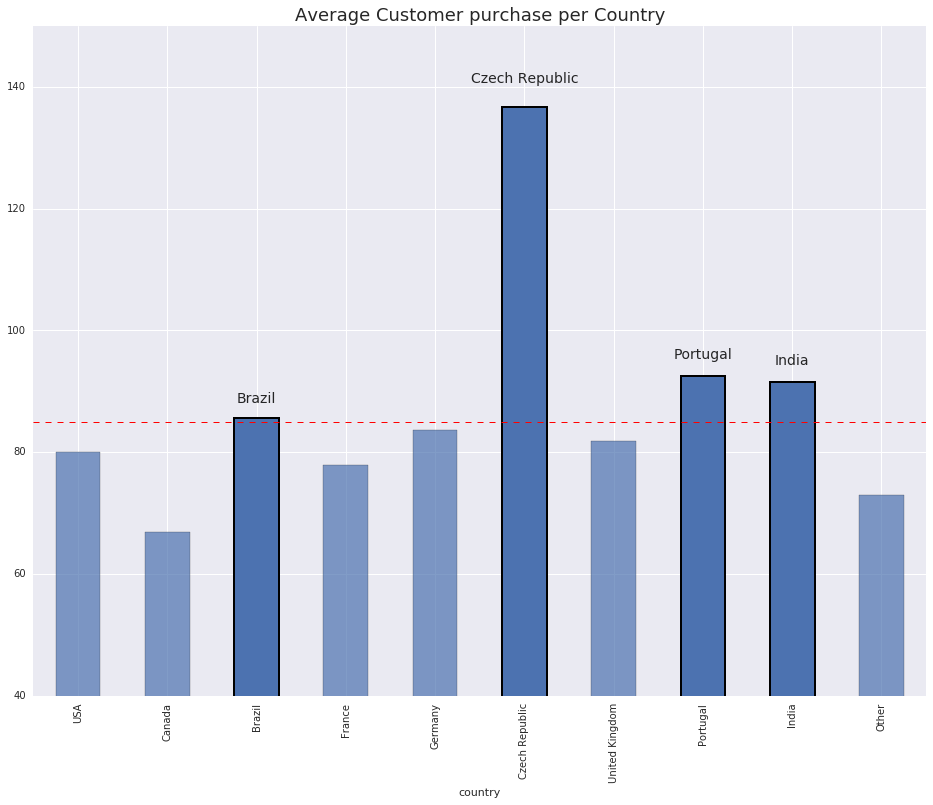

In [15]:
avg_customer_purchase()

Customers fromthe Czech Republic, Portugal, India, Brazil willing to spend more with their verage purchase more than 85 USD per customer.

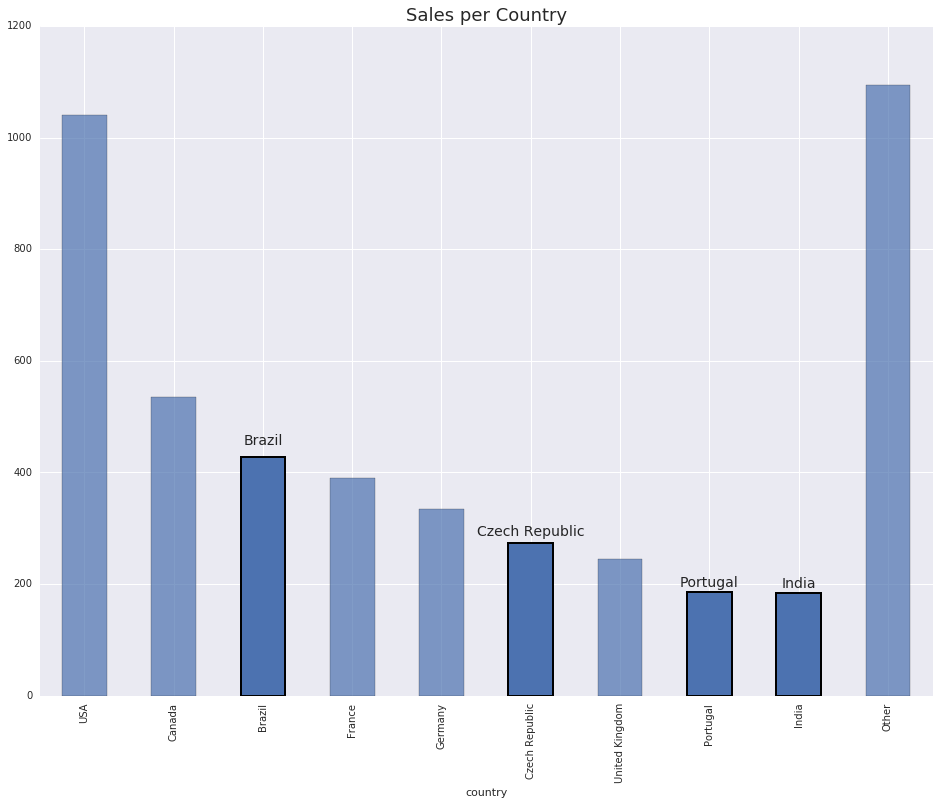

In [16]:
total_sales_per_country()

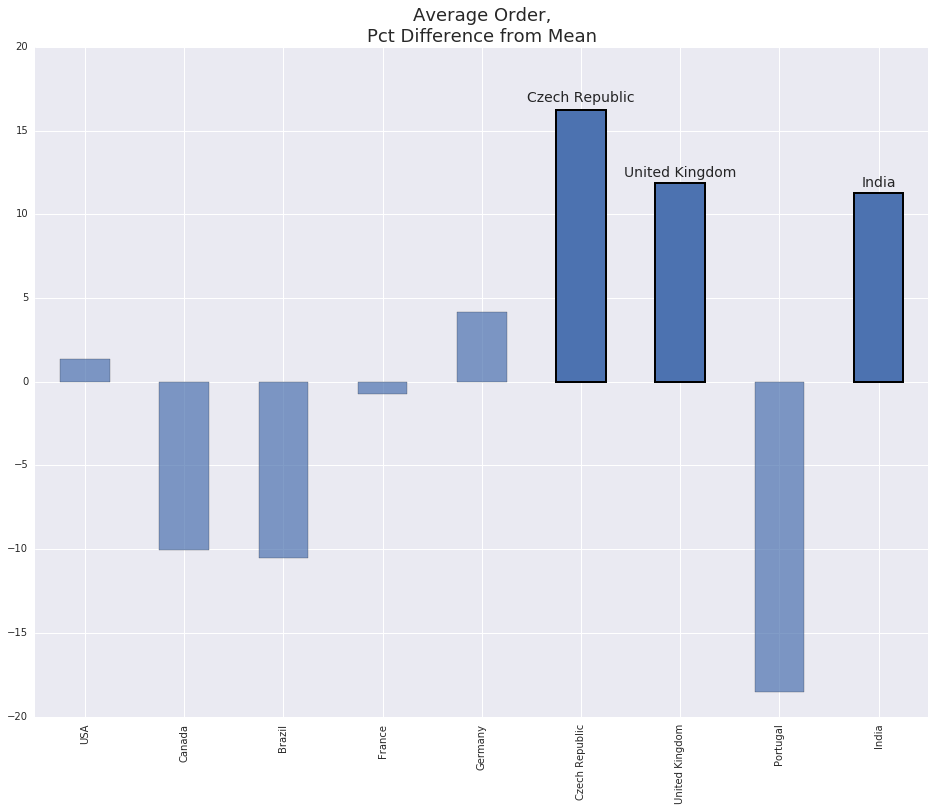

In [17]:
avg_order_per_country()

Czech Republic, UK, and India customers tend to make highest purchases per order, and certainly worth to focus on.

Top 3 countries with highest total sales: USA, Canada, Brazil. This group of countries have largest customer base.

Note: _It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers._

### Full Album Purchases
Let's find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to make their decision.

The strategy to consider is: to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

In [18]:
query = '''
    WITH invoice_tracks AS
    (SELECT 
        inv_l.invoice_id,
        inv_l.track_id
    FROM invoice_line inv_l
        ),
        
    album_tracks AS
    (SELECT
        tr.album_id album_id,
        tr.track_id tack_id
    FROM track tr
    ),
    
    invoice_album_id AS
    (SELECT
         inv_l.invoice_id invoice_id,
         alb.album_id
     FROM invoice_line inv_l
     INNER JOIN track tr ON tr.track_id=inv_l.track_id
     INNER JOIN album alb on alb.album_id=tr.album_id
     GROUP BY invoice_id
    ),
    
    is_album_purchase_table AS
    (SELECT
        inv_alb.invoice_id,
        inv_alb.album_id,
        CASE WHEN
                (SELECT tack_id
                FROM album_tracks alb_tr
                WHERE alb_tr.album_id=inv_alb.album_id
                    EXCEPT
                SELECT inv_tr.track_id
                FROM invoice_tracks inv_tr
                WHERE inv_tr.invoice_id=inv_alb.invoice_id)
                    IS NULL
             AND
                (SELECT inv_tr.track_id
                FROM invoice_tracks inv_tr
                WHERE inv_tr.invoice_id=inv_alb.invoice_id
                    EXCEPT
                SELECT tack_id
                FROM album_tracks alb_tr
                WHERE alb_tr.album_id=inv_alb.album_id)
                    IS NULL
            THEN 1
        ELSE 0
        END AS 'is_album_purchase'
    FROM invoice_album_id inv_alb)
    
    SELECT
        CASE WHEN
            is_alb.is_album_purchase=1 THEN 'YES'
        ELSE 'NO'
        END AS 'is_album_purchase',
        COUNT(*) invoice_qt,
        (SELECT COUNT(*) FROM is_album_purchase_table) invoice_total_qt,
        CAST(COUNT(*) AS float)/CAST((SELECT COUNT(*) FROM is_album_purchase_table is_album_purchase) AS float)*100 percentage
    FROM is_album_purchase_table is_alb
    GROUP BY is_album_purchase
'''

run_query(query)

,is_album_purchase,invoice_qt,invoice_total_qt,percentage
0,NO,500,614,81.433225
1,YES,114,614,18.566775


#### Conclusion
A large number of purchases (18.5%) are full-album purchases. Which is almost a firth of company revenue. I would recommend to continue buying full albums from record companies.

### Most popular artist
Which artist is used in most playlists?

In [19]:
query = '''
    SELECT
        art.name artist_name,
        art.artist_id artist_id,
        COUNT(tr.track_id) track_num
    FROM playlist pl
    INNER JOIN playlist_track pl_tr ON pl_tr.playlist_id=pl.playlist_id
    INNER JOIN track tr ON tr.track_id=pl_tr.track_id
    INNER JOIN album alb ON alb.album_id=tr.album_id
    INNER JOIN artist art ON art.artist_id=alb.artist_id
    GROUP BY art.artist_id
    ORDER BY track_num DESC
    LIMIT 5
'''

run_query(query)

,artist_name,artist_id,track_num
0,Iron Maiden,90,516
1,U2,150,333
2,Metallica,50,296
3,Led Zeppelin,22,252
4,Deep Purple,58,226


#### Conclusion
Most popular bands encountered in customer playlists are:
 - Iron Maiden
 - U2
 - Metallica
 - Led Zeppelin
 - Deep Purple
 
So, most Chinook customers find those bands awesome.

### Tracks Purchased vs non Purchased
Let's see how many of all tracks have been purchased.

In [20]:
query = '''    
    SELECT 
        (SELECT COUNT (DISTINCT track_id) tracks_purchased
            FROM invoice_line) tracks_purchased,
        (SELECT COUNT (DISTINCT track_id) total_tracks
            FROM track) total_tracks
'''

run_query(query)

,tracks_purchased,total_tracks
0,1806,3503


#### Conclusion
Roughly half of all track range have been purchased.

### Track range to popularity
Is the range of tracks in the store reflective of their sales popularity?

In [21]:
query = '''
    WITH total_track_range AS
        (SELECT COUNT (DISTINCT track_id) tot_tracks
                FROM track
        ),
    
    total_purchases AS
        (SELECT COUNT(track_id) tot_purchases
            FROM invoice_line
        ),
        
    purchases_per_genre AS        
        (SELECT
            g.name genre_name,
            COUNT(tr.track_id) tracks_purchased,
            CAST(COUNT(tr.track_id) AS float)/(SELECT * FROM total_purchases)*100 pct_of_all_purchases
        FROM genre g
        LEFT JOIN track tr ON g.genre_id=tr.genre_id
        LEFT JOIN invoice_line inv_l ON inv_l.track_id=tr.track_id
        GROUP BY g.genre_id)  
            
    SELECT
        g.name genre,
        COUNT(tr.track_id) track_num_range,
        CAST(COUNT(tr.track_id)AS float)/(SELECT * FROM total_track_range)*100 track_pct_range,
        purchases.tracks_purchased,
        purchases.pct_of_all_purchases pct_of_all_purchases
    FROM genre g
    INNER JOIN track tr ON tr.genre_id=g.genre_id
    LEFT JOIN purchases_per_genre AS purchases ON purchases.genre_name=g.name
    GROUP BY g.name
    ORDER BY track_pct_range DESC
'''

run_query(query)

,genre,track_num_range,track_pct_range,tracks_purchased,pct_of_all_purchases
0,Rock,1297,37.025407,3017,63.422325
1,Latin,579,16.528690,627,13.180576
2,Metal,374,10.676563,755,15.871347
3,Alternative & Punk,332,9.477591,648,13.622031
4,Jazz,130,3.711105,190,3.994114
5,TV Shows,93,2.654867,93,1.955014
6,Blues,81,2.312304,149,3.132226
7,Classical,74,2.112475,105,2.207273
8,Drama,64,1.827005,64,1.345386
9,R&B/Soul,61,1.741365,165,3.468573


In [46]:
track_purchases_df = run_query(query)
track_purchases = track_purchases_df[['genre','track_pct_range','pct_of_all_purchases']].copy()
# Set index to genre names, so that x ticks are named automatically
track_purchases.set_index('genre', inplace=True, drop=True)

In [47]:
horizontal_line_pct_separation = 5
horizontal_line_qt_separation = int(horizontal_line_pct_separation*track_purchases_df['track_num_range'].sum()/100)

def pct_track_distribution_all():
    title = 'Track percentage for sale distribution vs actual purchased\n(per genre)'

    fig3 = plt.figure(figsize=(16,12))
    # Add a subplot
    ax = fig3.add_subplot(111)
    # plot the graph
    track_purchases.plot.bar(ax=ax)

    ax.set_title(title, fontsize=18)

    # Add separation line, that visually displays large and small track quantity
    ax.axhline(horizontal_line_pct_separation, linestyle='--', linewidth=0.7)
    ax.text(20, horizontal_line_pct_separation+1, '> {} tracks'.format(horizontal_line_qt_separation), 
                             ha='left', color='black', fontsize=13, alpha=0.85)
    ax.text(20, horizontal_line_pct-1.5, '< {} tracks'.format(horizontal_line_qt_separation), 
                             ha='left', color='black', fontsize=13, alpha=0.85)

    plt.xticks(rotation=75);

In [48]:
tracks_large_qt = track_purchases[track_purchases['track_pct_range']>=horizontal_line_pct_separation]
tracks_small_qt = track_purchases[track_purchases['track_pct_range']<horizontal_line_pct_separation]

def pct_track_distribution_separately():
    fig = plt.figure(figsize=(16,14))
    # Add subplots
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    # plot the graphs
    tracks_large_qt.plot.bar(ax=ax1)
    tracks_small_qt.plot.bar(ax=ax2)
    plt.sca(ax1)
    plt.xticks(rotation=0, fontsize=14);
    plt.sca(ax2)
    plt.xticks(rotation=70, fontsize=14);

    ax1.set_title('Tracks for sale vs purchased % distribution\n>{}track volume'.format(horizontal_line_qt_separation),
                 fontsize=18)
    ax2.set_title('Tracks for sale vs purchased % distribution\n<{}track volume'.format(horizontal_line_qt_separation),
                 fontsize=18)

    ax2.set_ylim(0, horizontal_line_pct)
    fig.tight_layout()


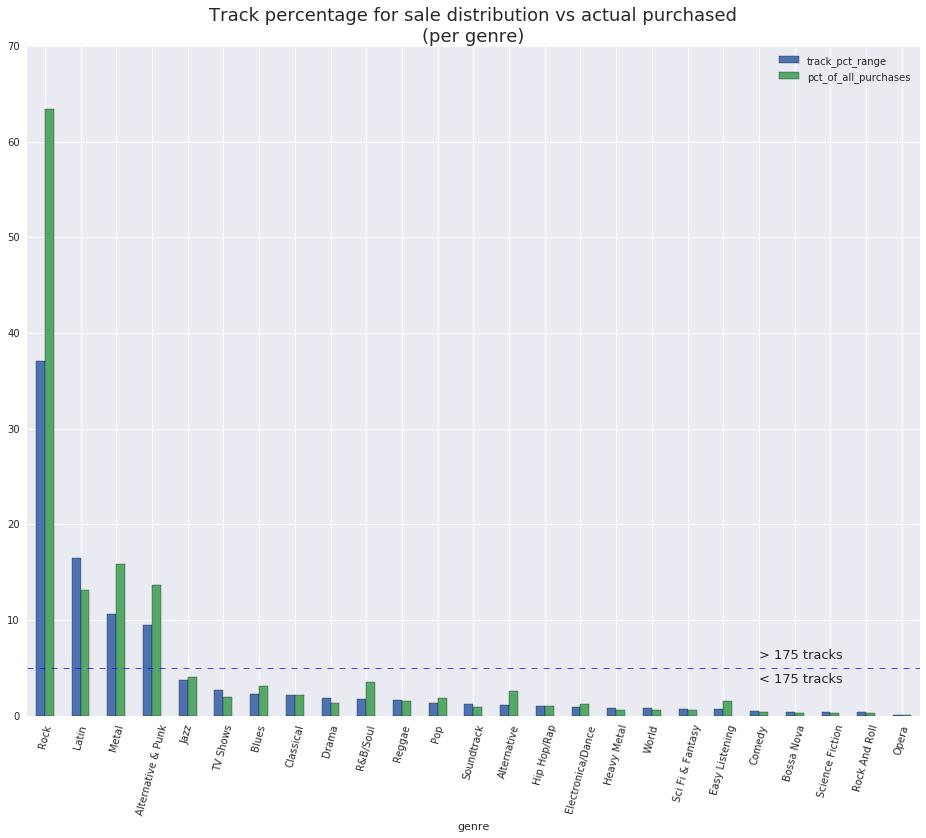

In [49]:
pct_track_distribution_all()

Visualize distributionsfor tracks >175 and <175 separately.

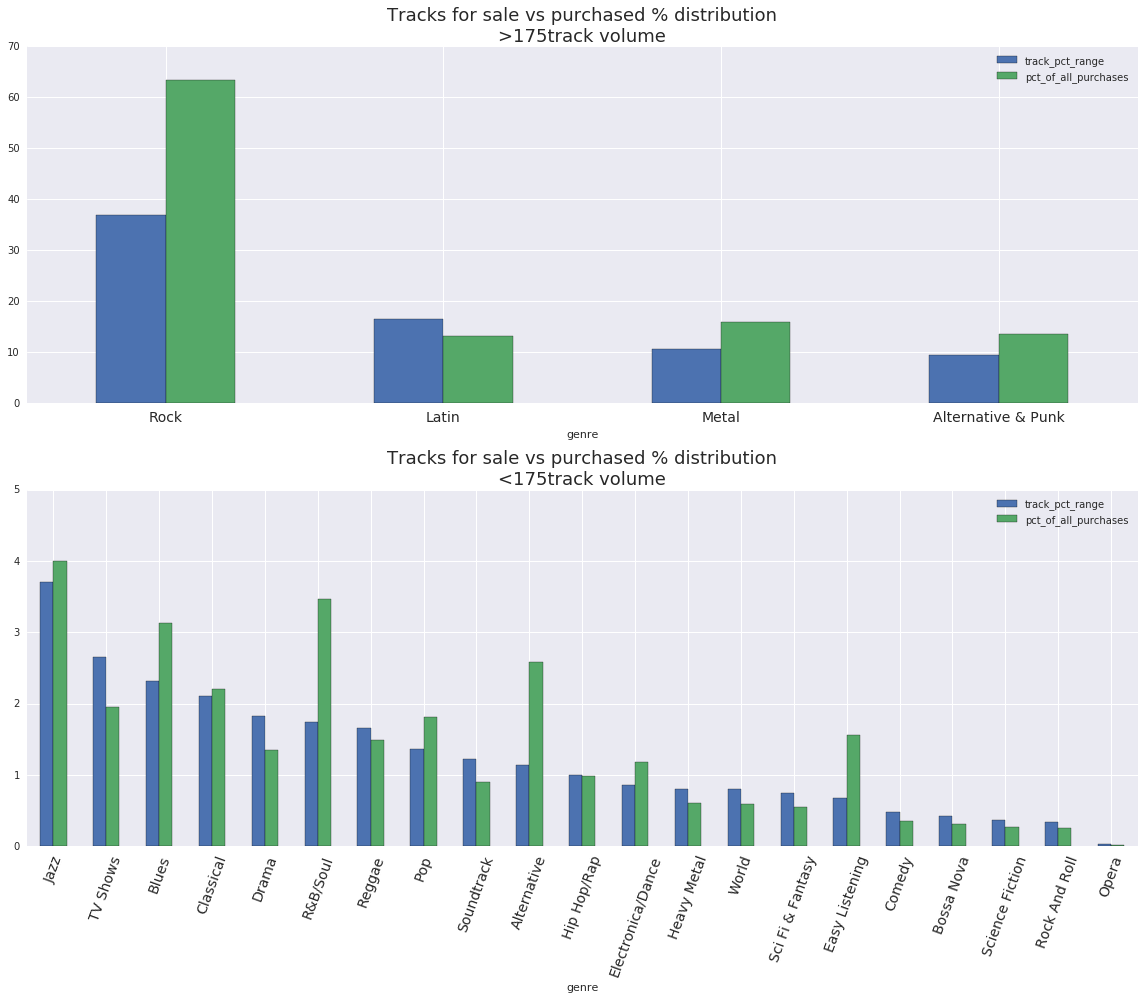

In [50]:
pct_track_distribution_separately()

#### Conclusion
We can see, that range of tracks for sale roughly reflects their sales popularity.

However, on a more detailed view, we can see that some genres have high variation of tracks for sale vs actual demand withing customers.

I would recommend to balance those out, especially for a group of genres with highest quantities of tracks.

My recommendation:
    - Increase range of **Rock** tracks twice
    - Increase range of **Metal** tracks by a quarter
    - Increase range of **Alternative & Punk** tracks by 20%

Additionally it is worth to increase the range of tracks for such genres as: R&B/Soul, Alternative, Easy Listening. As even though these categories are in low volume sales, they show customer demand of twice larger than that we offer.

### Media type to popularity
Do protected vs non-protected media types have an effect on popularity?

How can we define track popularity by media type? - That would be total tracks of that media type purchased , divided by tracks of that media type for sale.

In [57]:
query = '''
    WITH tracks_per_media_purchased AS
    (
    SELECT
        mt.media_type_id media_id,
        SUM(inv_l.track_id) tracks_purchased
    FROM invoice_line inv_l
    INNER JOIN track tr ON tr.track_id=inv_l.track_id
    INNER JOIN media_type mt ON mt.media_type_id=tr.media_type_id
    GROUP BY mt.media_type_id
    ),
    
    tracks_per_media_distinct AS
    (
    SELECT DISTINCT
        mt.media_type_id media_id,
        SUM(tr.track_id) tracks_distinct
    FROM track tr
    INNER JOIN media_type mt ON mt.media_type_id=tr.media_type_id
    GROUP BY mt.media_type_id
    )
    
    SELECT
        mt.name media,
        tr_p.tracks_purchased track_per_media_purchased,
        tr_d.tracks_distinct tracks_per_media_range,
        CAST(tr_p.tracks_purchased AS float)/tr_d.tracks_distinct*100 popularity_per_media
    FROM media_type mt
    LEFT JOIN tracks_per_media_purchased tr_p ON tr_p.media_id=mt.media_type_id
    LEFT JOIN tracks_per_media_distinct tr_d ON tr_d.media_id=mt.media_type_id
    ORDER BY popularity_per_media DESC
'''

run_query(query)

,media,track_per_media_purchased,tracks_per_media_range,popularity_per_media
0,Purchased AAC audio file,117252,24155,485.415028
1,AAC audio file,70462,36894,190.984984
2,Protected AAC audio file,1234957,676769,182.478364
3,MPEG audio file,6960341,4745832,146.662187
4,Protected MPEG-4 video file,9085,653606,1.389981


### Conclusion
To answer a question wheter protected/non-protected media type affects popularity, we can look at AAC audio files.

Data shows that AAC audio file popularity almost has no distinction for it's media type. Both media types popularities are on par: 191 and 182 for non-protected/protected media types respectively.

Additionally we've found out that video files are extremely unpopular in our store! _Video files happen to be of MPEG-4 protedted format, but popularity most probably is low regardless of format._